In [2]:
import pandas as pd 
import numpy as np  
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

movie_df = pd.read_csv('movie_master_dataset.csv', encoding = "ISO-8859-1")

top_genres = ['Action', 'Drama', 'Thriller', 'Comedy', 'Romance']
unpopular_genres = ['Documentary', 'Musical', 'History']

#Get the first 500 successful movies based on gross 
hg = movie_df.sort(['gross'], ascending = False)
hg = hg.reset_index(drop=True)
hg = hg.head(500)

directors = set(movie_df['director_name'].tolist()) 
director_hits = {} 
for director in directors: 
    df = hg[hg['director_name'] == director]
    director_hits[director] = len(df)

def get_movies(movie_df): 
    movies = [] 
    action = movie_df[movie_df['genres'].str.contains('Action')]
    movies.append(action)

    drama = movie_df[movie_df['genres'].str.contains('Drama')]
    movies.append(drama)

    thriller = movie_df[movie_df['genres'].str.contains('Thriller')]
    movies.append(thriller)
    
    comedy = movie_df[movie_df['genres'].str.contains('Comedy')]
    movies.append(comedy)
    
    romance = movie_df[movie_df['genres'].str.contains('Romance')]
    movies.append(romance)
    
    documentary = movie_df[movie_df['genres'].str.contains('Documentary')]
    movies.append(documentary)
    
    musical = movie_df[movie_df['genres'].str.contains('Musical')]
    movies.append(musical)
    
    history = movie_df[movie_df['genres'].str.contains('History')]
    movies.append(history)
    
    return movies

init_movies = get_movies(movie_df)

def get_hits(row): 
    return director_hits[row['director_name']] 

def get_title_length(row): 
    return len(row['movie_title'].split())
    
def get_actors_similarity(row): 
    actor_1 = row['actor_1_name']
    actor_2 = row['actor_2_name']
    actor_3 = row['actor_3_name']
    
    actor_1_vals = []
    actor_2_vals = [] 
    actor_3_vals = [] 
    for i in range(5): 
        ct_1 = init_movies[i][init_movies[i]['actor_1_name'] == actor_1]
        ct_2 = init_movies[i][init_movies[i]['actor_2_name'] == actor_2]
        ct_3 = init_movies[i][init_movies[i]['actor_3_name'] == actor_3]
        
        actor_1_vals.append(len(ct_1)) 
        actor_2_vals.append(len(ct_2)) 
        actor_3_vals.append(len(ct_3)) 
        
    d12, path = fastdtw(actor_1_vals, actor_2_vals, dist=euclidean) 
    d13, path = fastdtw(actor_1_vals, actor_3_vals, dist=euclidean)
    d23, path = fastdtw(actor_2_vals, actor_3_vals, dist=euclidean)
    avg = (d12 + d13 + d23)/3
    return avg 
    
    
#Retrieve hits for the director and format the movie duration 
movie_df['director_hits'] = movie_df.apply(lambda row: get_hits(row),axis=1)
movie_df['duration'] = movie_df['duration'].apply(lambda x: str(x))
movie_df['duration'] = movie_df['duration'].apply(lambda x: int(x[:3]) if x[0] == '1' else int(x[:2]))  
movie_df['title_len'] = movie_df.apply(lambda row: get_title_length(row), axis=1)  
movie_df['actors_similarity'] = movie_df.apply(lambda row: get_actors_similarity(row), axis=1)

movies = get_movies(movie_df)

def ols(data, features): 
    base = 'gross ~ '
    for feature in features: 
        if features.index(feature) == 0: 
            base += feature 
        else: 
            base += ' + ' + feature 
        
    model = smf.ols(formula=base, data=data).fit()
    model.summary()
    print(model.summary())

    fig = plt.figure(figsize=(12,10))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)

In [3]:
from scipy.stats import pearsonr

#Check for any correlation between the predictor variabales 
duration = movie_df['duration'].tolist() 
budget =  movie_df['budget'].tolist() 
director_hits = movie_df['director_hits'].tolist() 
title_len = movie_df['title_len'].tolist() 

duration_budget = pearsonr(duration, budget)
print('Correlation between duration and budget is ' + str(duration_budget[0])) 

duration_director_hits = pearsonr(duration, director_hits)
print("Correlation between duration and the director's number of successful movies is " + str(duration_director_hits[0])) 

duration_title_len = pearsonr(duration, title_len) 
print("Correlation between duration and the movie title's length is " + str(duration_title_len[0])) 

budget_director_hits = pearsonr(budget, director_hits)
print('Correlation between budget and the number of successful movie the director has made is ' + str(budget_director_hits[0]))

budget_title_len = pearsonr(budget, title_len)
print("Correlation between budget and the movie title's length is " + str(budget_title_len[0])) 

director_hits_title_len = pearsonr(budget, title_len)
print("Correlation between the director's number of successful movies and the movie title's length is " + str(director_hits_title_len[0])) 

Correlation between duration and budget is 0.154600369845
Correlation between duration and the director's number of successful movies is 0.21907653289
Correlation between duration and the movie title's length is 0.0136109941627
Correlation between budget and the number of successful movie the director has made is 0.101657688575
Correlation between budget and the movie title's length is 0.019354188818
Correlation between the director's number of successful movies and the movie title's length is 0.019354188818


Results for Action Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     48.73
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           5.29e-30
Time:                        15:40:36   Log-Likelihood:                -48239.
No. Observations:                1454   AIC:                         9.649e+04
Df Residuals:                    1450   BIC:                         9.651e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -1.847

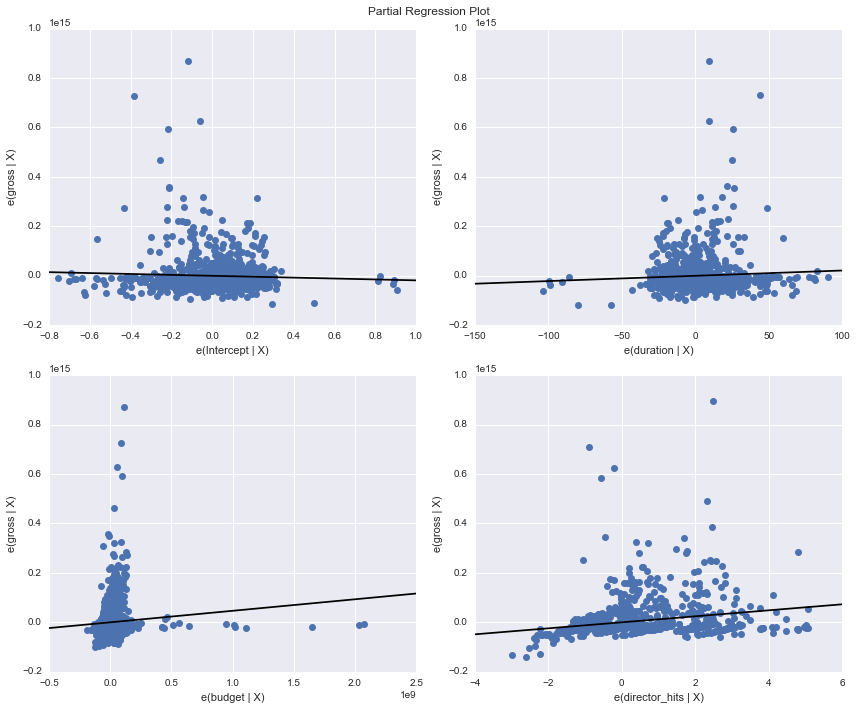

In [10]:
print('Results for ' + top_genres[0] + ' Movies')
ols(movies[0], ['duration', 'budget', 'director_hits'])

Results for Drama Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     77.43
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           6.53e-63
Time:                        15:41:22   Log-Likelihood:            -1.0914e+05
No. Observations:                3373   AIC:                         2.183e+05
Df Residuals:                    3368   BIC:                         2.183e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept    

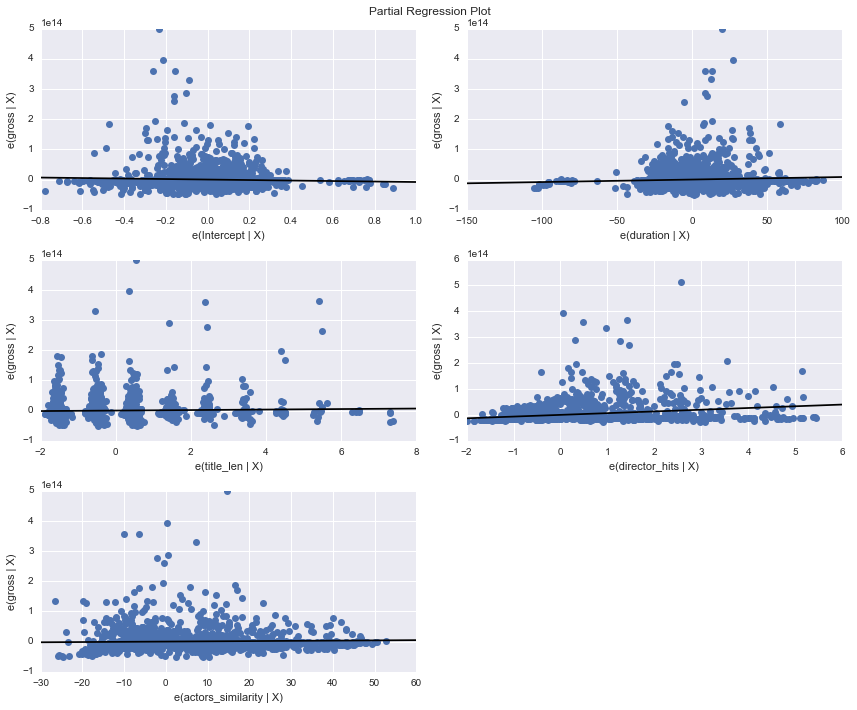

In [12]:
print('Results for ' + top_genres[1] + ' Movies')
ols(movies[1], ['duration', 'title_len', 'director_hits', 'actors_similarity'])

Results for Thriller Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     51.89
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           2.09e-41
Time:                        15:48:24   Log-Likelihood:                -58969.
No. Observations:                1804   AIC:                         1.179e+05
Df Residuals:                    1799   BIC:                         1.180e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept 

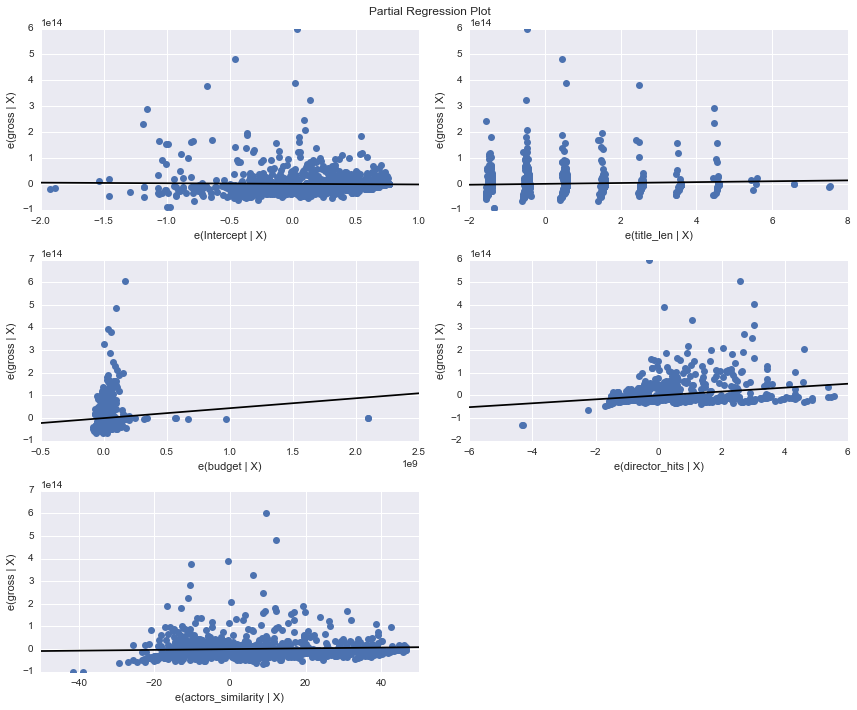

In [14]:
print('Results for ' + top_genres[2] + ' Movies')
ols(movies[2], ['title_len', 'budget', 'director_hits', 'actors_similarity'])

Results for Comedy Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     145.4
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           2.63e-60
Time:                        15:49:43   Log-Likelihood:                -78033.
No. Observations:                2392   AIC:                         1.561e+05
Df Residuals:                    2389   BIC:                         1.561e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      1.983

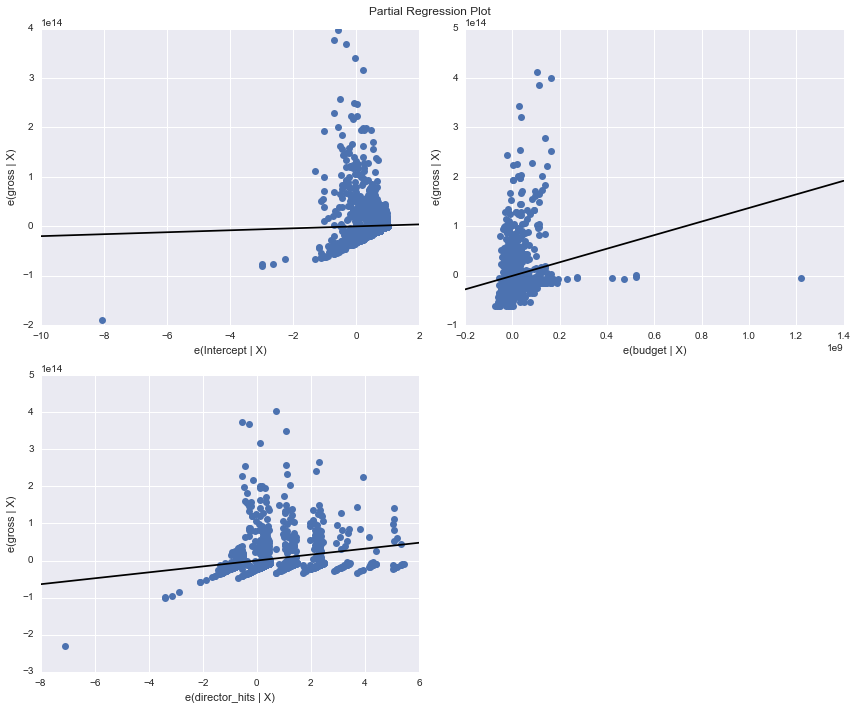

In [16]:
print('Results for ' + top_genres[3] + ' Movies')
ols(movies[3], ['budget', 'director_hits'])

Results for Romance Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     160.5
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           5.63e-35
Time:                        15:51:38   Log-Likelihood:                -47607.
No. Observations:                1468   AIC:                         9.522e+04
Df Residuals:                    1466   BIC:                         9.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      3.99

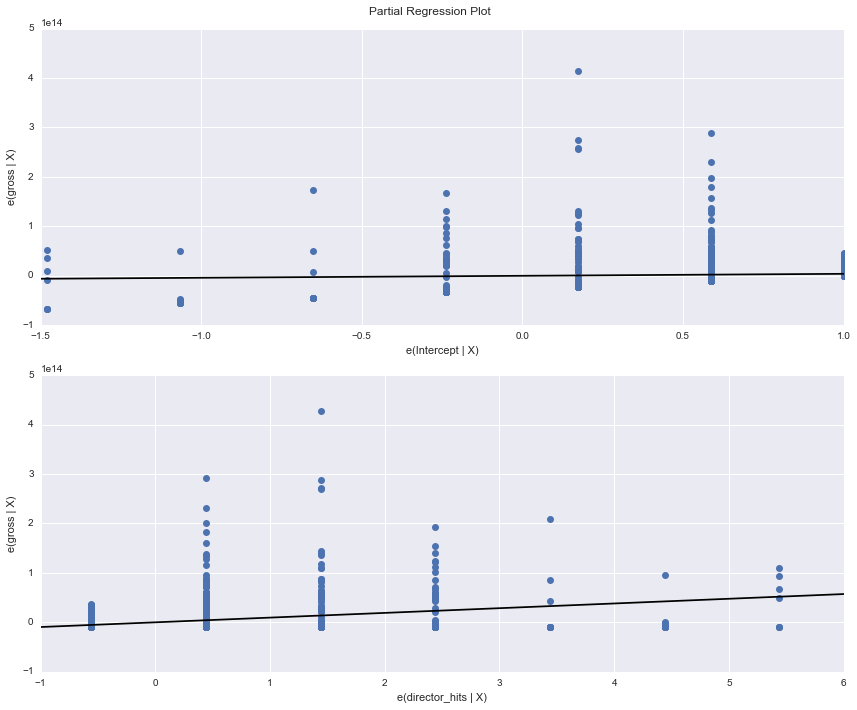

In [18]:
print('Results for ' + top_genres[4] + ' Movies')
ols(movies[4], ['director_hits'])

Results for Documentary Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                 -0.116
Method:                 Least Squares   F-statistic:                    0.6062
Date:                Sun, 11 Dec 2016   Prob (F-statistic):              0.697
Time:                        15:52:05   Log-Likelihood:                -373.62
No. Observations:                  20   AIC:                             759.2
Df Residuals:                      14   BIC:                             765.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Interce

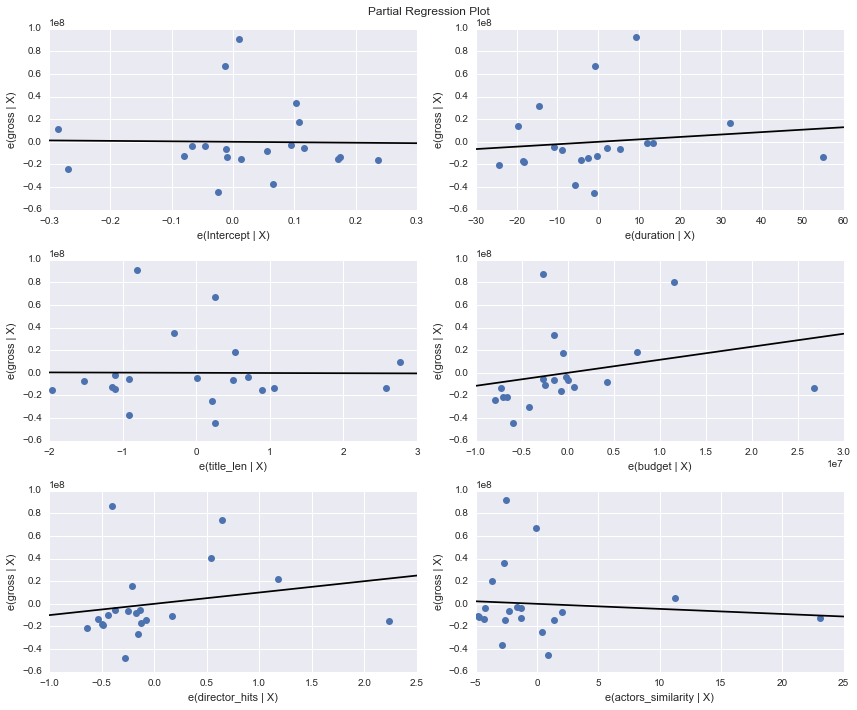

In [19]:
print('Results for ' + unpopular_genres[0] + ' Movies')
ols(movies[5], ['duration', 'title_len', 'budget', 'director_hits', 'actors_similarity'])

Results for Musical Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     16.37
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           8.57e-05
Time:                        15:55:22   Log-Likelihood:                -4665.3
No. Observations:                 142   AIC:                             9335.
Df Residuals:                     140   BIC:                             9341.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      4.81

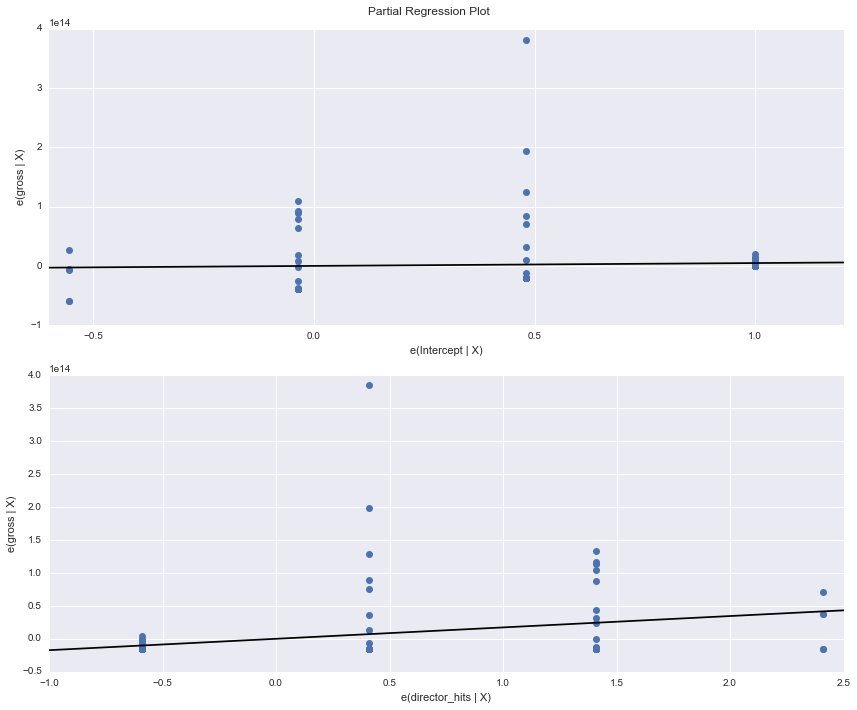

In [22]:
print('Results for ' + unpopular_genres[1] + ' Movies')
ols(movies[6], ['director_hits'])

Results for History Movies
                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     14.96
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           0.000138
Time:                        15:55:40   Log-Likelihood:                -8681.9
No. Observations:                 266   AIC:                         1.737e+04
Df Residuals:                     264   BIC:                         1.738e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      6.91

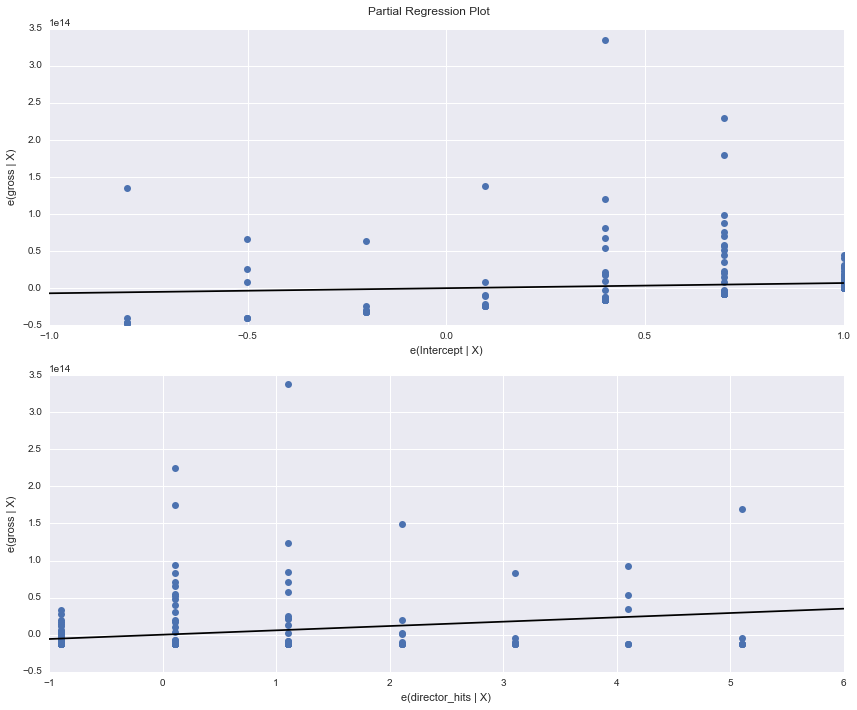

In [23]:
print('Results for ' + unpopular_genres[2] + ' Movies')
ols(movies[7], ['director_hits'])